In [1]:
from Class import SchwarzschildPerturbation, gaussian_initial_profile
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import fft, fftshift, ifft, ifftshift, fftfreq

In [10]:
j = complex(0, 1)

#Parameters
M = 1
l = 2
parity = 'axial'

rstar_min = -800
rstar_max = 800
dx = 0.08

#Initialise Simulation
axial_sim = SchwarzschildPerturbation(M, l, parity, rstar_min, rstar_max, dx = 0.08, dt = 0.4*dx)

#Initial data
width = 10*M
rstar0 = 200*M
omega = 0.5
Psi0 = 1/(np.sqrt(2*np.pi*width**2))*np.exp(-(axial_sim.rstar - rstar0)**2/(2*width**2))*np.exp(-j*omega*axial_sim.rstar)
dPsi0 = (-j*omega - (axial_sim.rstar - rstar0)/width**2)*Psi0

sim = axial_sim.solve(Psi0, 20000, dPsi0)


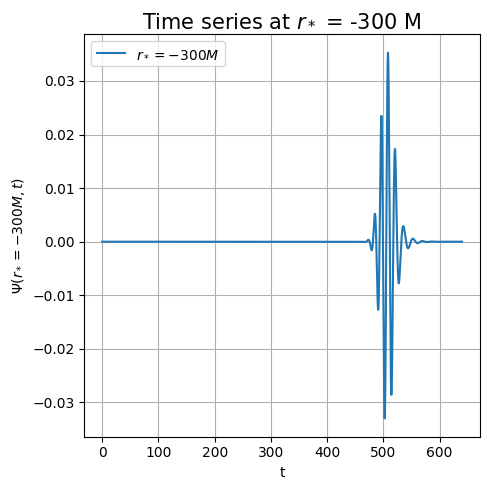

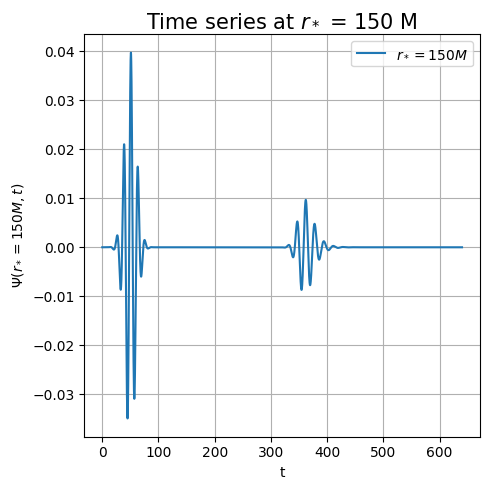

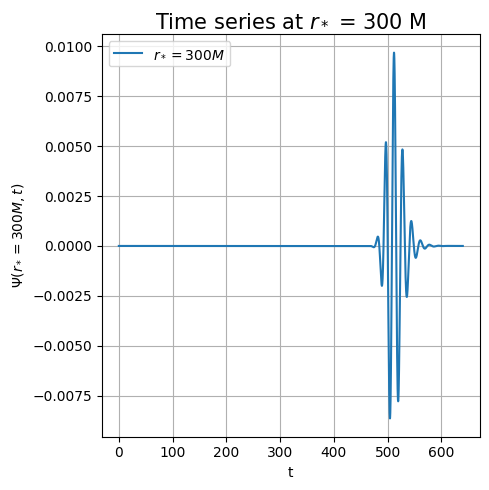

(3, 20000)


In [11]:
Psi = sim.Psi
times = sim.times

extraction_radii = [-300, 150, 300]

time_series = []
for x in extraction_radii:
    idx = np.argmin(np.abs(axial_sim.rstar - x*axial_sim.M))
    extraction = Psi[:, idx]
    time_series.append(extraction)
    plt.figure(figsize = (5, 5))
    plt.plot(times, extraction.real, label = rf'$r_* = {x} M$')
    plt.xlabel('t', fontsize = 10)
    plt.ylabel(rf'$\Psi (r_*={x} M, t)$', fontsize = 10)
    plt.title(rf'Time series at $r_*$ = {x} M', fontsize = 15)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

time_series = np.array(time_series)
print(time_series.shape)

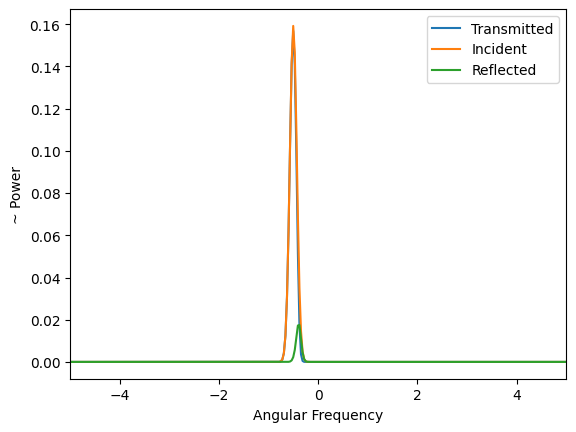

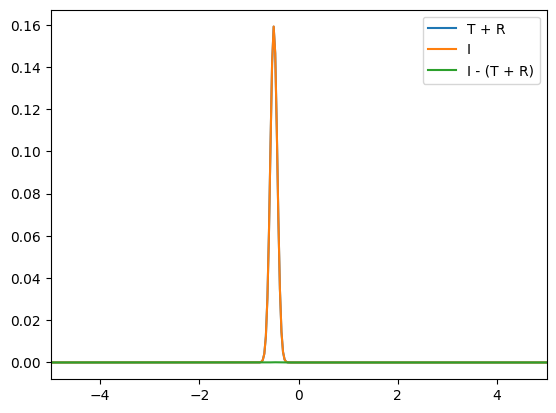

[-3.51900682e-17 -3.89605980e-17 -4.13835203e-17 ... -4.03509729e-17
 -3.61688201e-17 -3.52811154e-17]


In [12]:
transmitted = time_series[0]
t_lower = np.argmin(np.abs(times - 440))
t_upper = np.argmin(np.abs(times - 650))
transmitted_windowed = transmitted[t_lower:t_upper]

incident = time_series[1]
i_lower = np.argmin(np.abs(times - 0))
i_upper = np.argmin(np.abs(times - 100))
incident_windowed = incident[i_lower:i_upper]

reflected = time_series[2]
r_lower = np.argmin(np.abs(times - 450))
r_upper = np.argmin(np.abs(times - 625))
reflected_windowed = reflected[r_lower:r_upper]

n = int(transmitted_windowed.shape[0])
q = int(incident_windowed.shape[0])
p = int(reflected_windowed.shape[0])

lengths = np.array([n, q, p])
N_fft = np.max(lengths)

transmitted_padded = np.zeros(N_fft, dtype = complex)
transmitted_padded[:n] = transmitted_windowed

incident_padded = np.zeros(N_fft, dtype = complex)
incident_padded[:q] = incident_windowed

reflected_padded = np.zeros(N_fft, dtype = complex)
reflected_padded[:p] = reflected_windowed

omega = 2*np.pi*fftfreq(N_fft, d=sim.dt)
omega = fftshift(omega)

transmitted_FT = fftshift(fft(transmitted_padded))*sim.dt/np.sqrt(2*np.pi)
transmitted_power = np.abs(transmitted_FT)**2

incident_FT = fftshift(fft(incident_padded))*sim.dt/np.sqrt(2*np.pi)
incident_power = np.abs(incident_FT)**2

reflected_FT = fftshift(fft(reflected_padded))*sim.dt/np.sqrt(2*np.pi)
reflected_power = np.abs(reflected_FT)**2


plt.figure()
plt.plot(omega, transmitted_power, label = 'Transmitted')
plt.plot(omega, incident_power, label = 'Incident')
plt.plot(omega, reflected_power, label = 'Reflected')
plt.ylabel('~ Power')
plt.xlabel('Angular Frequency')
plt.xlim(-5, 5)
plt.legend()
plt.show()

plt.figure()
plt.plot(omega, reflected_power + transmitted_power, label = 'T + R')
plt.plot(omega, incident_power, label = 'I')
plt.plot(omega, incident_power - (reflected_power + transmitted_power), label = 'I - (T + R)')
plt.legend()
plt.xlim(-5, 5)
plt.show()

print(incident_power - (reflected_power + transmitted_power))

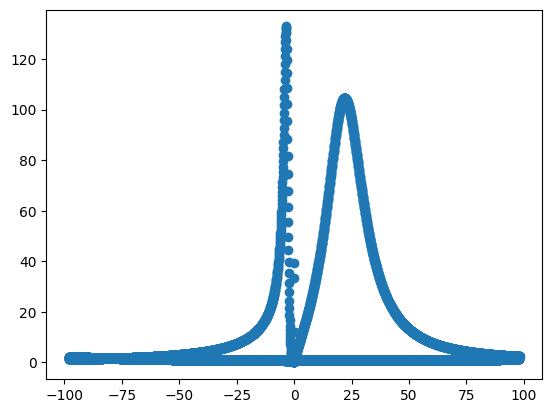

In [13]:
Gamma = transmitted_power/incident_power
Kappa = reflected_power/incident_power

plt.figure()
plt.scatter(omega, Gamma, label = 'Grey body factor')
plt.show()